# Importing libraries

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime
import plotly.graph_objects as go
from darts.models import Prophet
from darts import TimeSeries
from darts.utils.model_selection import train_test_split
from darts.metrics import mse, mae, mape

import glob 
import os
from tqdm import tqdm
import re
import pandas as pd
import numpy as np
import os

### Testing For Stationarity
from statsmodels.tsa.stattools import adfuller

# Create subplots with one trace per page using go object of plotly.graph_objs module 
import plotly.graph_objs as go

# Import TimeSeries class from darts library
try:
    from darts import TimeSeries
except ImportError:
    !pip install darts
    from darts import TimeSeries

import matplotlib.pyplot as plt
import glob
import warnings
warnings.filterwarnings("ignore")
from darts.models.forecasting.rnn_model import RNNModel 
import torch
import torch.nn as nn
import torch.optim as optim
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from darts.metrics import mape 

# Pandas is an open-source data manipulation and analysis library
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices
# The datetime module supplies classes for working with dates and times
# Plotly is a Python library that provides an interface for creating interactive plots and charts
# Darts is a library for easy manipulation of time series data and forecasting
# Sklearn is a library that provides simple and efficient tools for predictive data analysis
# Pandas_datareader is a library that provides access to online financial data sources
# Prettytable is a library for generating ASCII tables from data

# Import the necessary functions and modules for testing stationarity
# The adfuller function from statsmodels.tsa.stattools module is used to perform the Augmented Dickey-Fuller test for stationarity

# Create subplots with one trace per page using go object of plotly.graph_objs module 

# Import the TimeSeries class from the darts library
# If the import fails, install the darts library and then import the TimeSeries class

# Matplotlib is a plotting library for the Python programming language
# Glob is a module that finds all the pathnames matching a specified pattern according to the rules used by the Unix shell
# Warnings is a module that provides a mechanism to control warning messages in Python
# The RNNModel class from darts.models.forecasting.rnn_model module is used for building recurrent neural network models
# Torch is a machine learning library that provides support for building deep learning models
# PyTorch Lightning is a lightweight PyTorch wrapper for high-performance AI research
# The mape function from darts.metrics module is used for calculating the Mean Absolute Percentage Error



# Main points
* Missing Values
* Downsampling
    * 1 Hour 
    * 15 mints
    * 1 day

## Visualization Helping functions

In [2]:
def plot(df,x_feature_name,y_feature_name,title):
    """
    This function takes two dataframes as input and plots the number of calls per day and per week.

    Args:
    daily_df (pandas.DataFrame): A dataframe containing daily call data.
    weekly_df (pandas.DataFrame): A dataframe containing weekly call data.

    Returns:
    None
    """
    os.makedirs('data-pattern-on-different-sampling-freq',exist_ok=True)
    # Create a subplot with two rows and one column
    # fig = make_subplots(rows=2, cols=1)
    fig = go.Figure()
    # Add a trace for daily calls
    fig.add_trace(
        go.Scatter(
            x=df[x_feature_name],
            y=df[y_feature_name],
            name=y_feature_name,
            mode='lines+markers'
        ))

 

    # Update xaxis properties
    fig.update_xaxes(title_text='Date')

    # Update yaxis properties
    fig.update_yaxes(title_text=y_feature_name)

    # Update title and height
    fig.update_layout(
        title=f'{title}',
        height=500,
        width=1200
    )

    # Show the plot
    # fig.show()

    # Write the plot to an HTML file
    fig.write_html(f'data-pattern-on-different-sampling-freq/{title}.html')
    
def train_test_predicted_plot(df_train,
                              df_test,
                              x_feature ,
                              y_feature,
                              predicted, 
                              model_name):
    """
    Plots the training data, actual values, and forecasted values using Plotly.

    Args:
        train (pd.Series): The training data.
        test (pd.Series): The actual values.
        predicted (pd.Series): The forecasted values.
        model_name (str): The name of the forecasting model.

    Returns:
        None
    """

    # Create a subplot with two rows and one column
    fig = go.Figure()

    fig.add_trace(
    go.Scatter(
        x=df_train[x_feature],
        y=df_train[y_feature],
        name='Training Data',
        mode='lines+markers'
    ))

    # Add a trace for actual values
    fig.add_trace(
        go.Scatter(
            x=df_test[x_feature],
            y=df_test[y_feature],
            name='Actual Values',
            mode='lines+markers'
        )
    )
    # Add a trace for forecasted values
    fig.add_trace(
        go.Scatter(
            x=predicted[x_feature],
            y=predicted[y_feature],
            name=f'{model_name}',
            mode='lines+markers'
        )
    )

    # Update xaxis properties
    fig.update_xaxes(title_text='Time')

    # Update yaxis properties
    fig.update_yaxes(title_text=y_feature)

    # Update title and height
    fig.update_layout(
        title=f'Forecasting using {model_name}',
        height=500,
        width=1500
    )

    # Save the plot as an HTML file
    fig.show()
    os.makedirs('Visualization_models_results',exist_ok=True)
    fig.write_html(f'Visualization_models_results/forecasting_using_{model_name}'+'.html')
  


# Code Sample for visualization

In [ ]:
# path_lists = glob.glob('GreenD_reduced/'+'*.csv')
# for path in tqdm(path_lists ,desc='processing'):
    
#     data = pd.read_csv(path)
#     data['Timestamp'] = pd.to_datetime(data['Timestamp'],utc=True,unit='s')#format='%Y-%m-%d %H-%M-%S')
#     data['Timestamp'] = data['Timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

#     df = data 
#     x_feature_name = 'Timestamp'
#     y_feature_name = 'Summe'
#     title = path.split('/')[-1].split('.')[0]
#     plot(df,x_feature_name,y_feature_name,title)
    

In [3]:
path_lists = glob.glob('GreenD_reduced_version_03/'+'*.csv')
sorted_file_paths = sorted(path_lists)
def extract_digits(string):
    # Extract digits from the string using regular expression
    digits = re.findall(r'\d+', string)
    return int(digits[0]) if digits else 0

sorted_file_paths = sorted(path_lists, key=extract_digits)
print(sorted_file_paths)

conct_list = []
for path in tqdm(sorted_file_paths ,desc='processing'):
    
    data = pd.read_csv(path)
    data['Timestamp'] = pd.to_datetime(data['Timestamp'],utc=True,unit='s')#format='%Y-%m-%d %H-%M-%S')
    data['Timestamp'] = data['Timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
    conct_list.append(data)
!mkdir 'Combined-Dataset-version-03'
df = pd.concat(conct_list)
# df.to_csv('Combined-Dataset-version-03/single_file.csv',index=False)

['GreenD_reduced_version_03/greend_dataset_466.csv', 'GreenD_reduced_version_03/greend_dataset_341.csv', 'GreenD_reduced_version_03/greend_dataset_137.csv', 'GreenD_reduced_version_03/greend_dataset_32.csv', 'GreenD_reduced_version_03/greend_dataset_370.csv', 'GreenD_reduced_version_03/greend_dataset_35.csv', 'GreenD_reduced_version_03/greend_dataset_180.csv', 'GreenD_reduced_version_03/greend_dataset_204.csv', 'GreenD_reduced_version_03/greend_dataset_114.csv', 'GreenD_reduced_version_03/greend_dataset_377.csv', 'GreenD_reduced_version_03/greend_dataset_338.csv', 'GreenD_reduced_version_03/greend_dataset_179.csv', 'GreenD_reduced_version_03/greend_dataset_363.csv', 'GreenD_reduced_version_03/greend_dataset_80.csv', 'GreenD_reduced_version_03/greend_dataset_78.csv', 'GreenD_reduced_version_03/greend_dataset_464.csv', 'GreenD_reduced_version_03/greend_dataset_74.csv', 'GreenD_reduced_version_03/greend_dataset_365.csv', 'GreenD_reduced_version_03/greend_dataset_387.csv', 'GreenD_reduced_

processing: 100%|██████████| 472/472 [00:31<00:00, 14.95it/s]

mkdir: cannot create directory ‘Combined-Dataset-version-03’: File exists


In [4]:
df.sort_values(by='Timestamp',inplace=True)

In [4]:
def downsample_dataframe(df, downsampling_frequency, fill_method='mean'):
  """
  Downsamples a DataFrame and fills missing values.

  Args:
    df: The DataFrame to downsample.
    downsampling_frequency: The frequency to downsample the DataFrame to.
    fill_method: The method to use to fill missing values.

  Returns:
    The downsampled DataFrame.
  """

  # Convert the Timestamp column to a datetime object.
  df['Timestamp'] = pd.to_datetime(df['Timestamp'])

  # Set the index of the DataFrame to the Timestamp column.
  df = df.set_index('Timestamp')

  # Fill the missing values.
  if fill_method == 'mean':
    df = df.fillna(df.mean())
  elif fill_method == 'median':
    df = df.fillna(df.median())
  else:
    raise ValueError('Invalid fill_method: {}'.format(fill_method))

  # Downsample the DataFrame.
  df = df.resample(downsampling_frequency).mean()
  return df
  # Check if any missing values were created after downsampling.
  if df.isna().any():
    df = df.fillna(df.mean())

  return df


# Filling Missing Values

In [ ]:
# !mkdir 'clean_datasets'

# df = pd.read_csv('Combined-Dataset-version-03/single_file.csv')
# df['Timestamp'] =  pd.to_datetime(df['Timestamp'])
# df.fillna(df.mean(),inplace=True)
# df.to_csv('clean_datasets/downsample_5_sec.csv',index=False)



# Data Sample

In [ ]:
# df = pd.read_csv('clean_datasets/downsample_5_sec.csv')
# df['Timestamp'] = pd.to_datetime(df['Timestamp'])
# df = df.set_index('Timestamp')
# df_1_hour = df.resample('1H').mean()
# df_1_day = df.resample('1d').mean()


In [ ]:
df.info()

In [5]:
# df = pd.read_csv('clean_datasets/downsample_5_sec.csv')

# # Downsample the DataFrame to 1-hour frequency and fill missing values using mean imputation.
# df_1_hour = downsample_dataframe(df, '1H', fill_method='mean')
# df_1_hour.reset_index('Timestamp',inplace=True)
# df_1_hour.fillna(method='ffill',inplace=True)

# # # Downsample the DataFrame to 15-minute frequency and fill missing values using median imputation.
# # df_15_min = downsample_dataframe(df, '15T', fill_method='mean')
# # df_15_min.reset_index('Timestamp',inplace=True)
# # df_15_min.fillna(method='ffill',inplace=True)

# # # Downsample the DataFrame to 30-minute frequency and fill missing values using median imputation.
# # df_30_min = downsample_dataframe(df, '30T', fill_method='mean')
# # df_30_min.reset_index('Timestamp',inplace=True)
# # df_30_min.fillna(method='ffill',inplace=True)

# # # Downsample the DataFrame to 1 Day frequency and fill missing values using median imputation.
# # df_1_day = downsample_dataframe(df, '1d', fill_method='mean')
# # df_1_day.reset_index('Timestamp',inplace=True)
# # df_1_day.fillna(method='ffill',inplace=True)

# # # Downsample the DataFrame to 7 Day frequency and fill missing values using median imputation.
# # df_7_day = downsample_dataframe(df, '7d', fill_method='mean')
# # df_7_day.reset_index('Timestamp',inplace=True)
# # df_7_day.fillna(method='ffill',inplace=True)

# Downsample the DataFrame to 1-hour frequency and fill missing values using mean imputation.
df_1_hour = downsample_dataframe(df, '1H', fill_method='mean')
df_1_hour.reset_index('Timestamp',inplace=True)
df_1_hour.fillna(method='ffill',inplace=True)


In [ ]:
df = df_1_hour
x_feature_name = 'Timestamp'
y_feature_name = 'Summe'
title = '1-Hour'
plot(df,x_feature_name,y_feature_name,title)


# Forecasting using ARIMA Model
* **Box-Jenkins Framework**
The Box-Jenkins method is a statistical technique used for time series analysis and forecasting. The approach starts with the assumption that the process that generated the time series can be approximated using an ARMA model if it is stationary or an ARIMA model if it is non-stationary.

* The Box-Jenkins method applies autoregressive moving average (ARMA) or autoregressive integrated moving average (ARIMA) models to find the best fit of a time-series model to past values of a time series2. The model can analyze several different types of time series data for forecasting purposes3.

* **ARIMA Model Pipeline**
    * Autoregressive Integrated Moving Average (ARIMA) Model
    * autoregressive models: AR(p)
    * moving average models: MA(q)
    * mixed autoregressive moving average models: ARMA(p, q)
    * integration models: ARIMA(p, d, q)

* Stationary Test
    * What is stationary Data ?
        * Stationary data refers to time series data that mean and variance do not vary across time. The data is considered non-stationary if there is a strong trend or seasonality observed from the data.

Why we need stationary Data for ARIMA Model
ARIMA models rely on the assumption that the time series being modeled is stationary. Therefore that assumption needs to hold if you want to use these models. The ARIMA model uses differenced data to make the data stationary, which means there’s a consistency of the data over time. This function removes the effect of trends or seasonality, such as market or economic data. We make the data stationary only in case of ARIMA because the ARIMA model looks at the past data to predict future values.

Stationary Test

In [ ]:
def adfuller_test(values):
    result=adfuller(values)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("P value is less than 0.05 that means we can reject the null hypothesis(Ho). Therefore we can conclude that data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis that means time series has a unit root which indicates that it is non-stationary ")

adfuller_test(df_1_hour['Summe'])


# Data PreProcessing

In [8]:
# df_1_day_indexed = df_1_day.set_index('Timestamp')
# # Set the 'Timestamp' column as the index of the DataFrame df_1_day
# day_ts = TimeSeries.from_dataframe(df_1_day_indexed, freq='1d')
# # Create a TimeSeries object 'day_ts' from the indexed DataFrame df_1_day_indexed with a frequency of 1 day

df_1_hour_indexed = df_1_hour.set_index('Timestamp')
# Set the 'Timestamp' column as the index of the DataFrame df_1_hour
hour_ts = TimeSeries.from_dataframe(df_1_hour_indexed, freq='1h')
# Create a TimeSeries object 'hour_ts' from the indexed DataFrame df_1_hour_indexed with a frequency of 1 hour

# train_day_ts, test_day_ts = day_ts.split_after(0.90)
# Split the 'day_ts' TimeSeries into a training set containing 90% of the data and a testing set containing the remaining 10%
train_hour_ts, test_hour_ts = hour_ts.split_after(0.90)
# Split the 'hour_ts' TimeSeries into a training set containing 98% of the data and a testing set containing the remaining 2%

print('Shape of train set:', train_hour_ts.pd_dataframe().shape)
print('Shape of test set:', test_hour_ts.pd_dataframe().shape)
# Print the shape of the training set and testing set for the hourly data
Horizon_hour = test_hour_ts.pd_dataframe().shape[0]
# Get the number of rows (time steps) in the testing set for the hourly data

# print('Shape of train set:', train_day_ts.pd_dataframe().shape)
# print('Shape of test set:', test_day_ts.pd_dataframe().shape)
# Print the shape of the training set and testing set for the daily data
# Horizon = test_day_ts.pd_dataframe().shape[0]
# Get the number of rows (time steps) in the testing set for the daily data


Shape of train set: (10252, 1)
Shape of test set: (1139, 1)


# Inspect Seasonality

In [ ]:
from darts.utils.statistics import plot_acf, check_seasonality

# Import the necessary functions from darts.utils.statistics module
# The plot_acf function is used to plot the autocorrelation function (ACF) of a time series
# The check_seasonality function is used to check for seasonality in a time series

for m in range(2, 25):
    # Iterate over the range from 2 to 24 (inclusive)
    
    is_seasonal, period = check_seasonality(hour_ts, m=m, alpha=0.05)
    # Check for seasonality in the time series day_ts using a period of m and a significance level of 0.05
    # The check_seasonality function returns a boolean indicating whether seasonality is present and the estimated period if seasonality is detected
    
    if is_seasonal:
        # If seasonality is detected
        print("There is seasonality of order {}.".format(period))
        # Print the detected seasonality order


# Auto Correlation plot
The autocorrelation function (ACF) is used to identify the order of ARIMA models. The ACF plot shows the correlation between the time series and its lagged version. The lag at which the ACF plot crosses the upper confidence interval for the first time is considered as the order of the MA component of the ARIMA model. Similarly, if the ACF plot decays slowly, it indicates that there is a high degree of autocorrelation in the time series, which means that an AR component or p parameters should be included in the ARIMA model.

In [ ]:
from darts.utils.statistics import plot_acf, plot_pacf

# Import the necessary functions from darts.utils.statistics module
# The plot_acf function is used to plot the autocorrelation function (ACF) of a time series
# The plot_pacf function is used to plot the partial autocorrelation function (PACF) of a time series

plot_acf(hour_ts, m=35, max_lag=100, fig_size=(10, 5), axis=None, default_formatting=True)
# Plot the ACF of the time series day_ts with a maximum lag of 100 and a lag multiple of 35
# The fig_size parameter sets the size of the figure to (10, 5)
# The axis parameter specifies the axis object to use for plotting, or None to create a new figure
# The default_formatting parameter determines whether to apply default formatting to the plot

plt.xlabel('lags')
plt.ylabel('correlation')
plt.title('Auto Correlation Plot')
# Set the x-axis label to 'lags', y-axis label to 'correlation', and the title of the plot to 'Auto Correlation Plot'

plt.show()
# Display the plot


# Partial Auto Correlation plot
The partial autocorrelation function (PACF) is also used to identify the order of ARIMA models. The PACF plot shows the correlation between the time series and its lagged version, but with the influence of the intermediate lags removed. The lag at which the PACF plot crosses the upper confidence interval for the first time is considered as the order of the AR component of the ARIMA model.

In [ ]:
from darts.utils.statistics import plot_acf, plot_pacf

# Import the necessary functions from darts.utils.statistics module
# The plot_acf function is used to plot the autocorrelation function (ACF) of a time series
# The plot_pacf function is used to plot the partial autocorrelation function (PACF) of a time series

plot_pacf(hour_ts, m=6, max_lag=50, fig_size=(10, 5), axis=None, default_formatting=True)
# Plot the PACF of the time series day_ts with a maximum lag of 50 and a lag multiple of 6
# The fig_size parameter sets the size of the figure to (10, 5)
# The axis parameter specifies the axis object to use for plotting, or None to create a new figure
# The default_formatting parameter determines whether to apply default formatting to the plot

plt.xlabel('lags')
plt.ylabel('correlation')
plt.title('Partial Auto Correlation Plot of FM_SUM')
# Set the x-axis label to 'lags', y-axis label to 'correlation', and the title of the plot to 'Partial Auto Correlation Plot of FM_SUM'

plt.show()
# Display the plot


# ARIMA Model

In [ ]:
from darts.models.forecasting.arima import ARIMA
from darts.metrics.metrics import  mape

# these parameters has been found using correlation plot and partial correlation plots
# i added the description there please read that paragraph # and we can also test 
# other order by try and test method
# p: The order of the auto-regressive (AR) model (i.e., the number of lag observations). A time series is considered AR when previous values in the time series are very predictive of later values.

# d: The degree of differencing.

# q: The order of the moving average (MA) model. This is essentially the size of the “window” function over your time series data.
arima_model =  ARIMA(p= 3, #, for Auto regressive parameter
                     d=1  , # for difference to make the data is statioanry
                     q = 3 ,  # for the moving Average,
                     seasonal_order=(3, 1, 3, 5)

                     )
arima_model.fit(train_hour_ts)



In [ ]:

predictions = arima_model.predict(Horizon_hour)

# Convert train_series into a pandas dataframe and reset index
df_train = train_hour_ts.pd_dataframe().reset_index()

# Convert test_series into a pandas dataframe and reset index
df_test = test_hour_ts.pd_dataframe().reset_index()

# Convert prediction into a pandas dataframe and reset index
forecast = predictions.pd_dataframe().reset_index()


x_feature ='Timestamp' 
y_feature='Summe'
model_name =f'ARIMA_Model'
train_test_predicted_plot(df_train,df_test,x_feature,y_feature,forecast,model_name)


# Error Calculation Functions

In [ ]:
import numpy as np

def calculate_errors(predicted, actual):
    # Convert lists to numpy arrays
    predicted = np.array(predicted)
    actual = np.array(actual)

    # Mean Absolute Error (MAE)
    mae = np.mean(np.abs(predicted - actual))

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(np.mean((predicted - actual) ** 2))

    # Mean Squared Error (MSE)
    mse = np.mean((predicted - actual) ** 2)

    # Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100

    return mae, rmse, mse, mape
test_mae , test_rmse , test_mse,test_mape = calculate_errors(forecast['Summe'] ,df_test['Summe'])

print(f"MAE : {test_mae} RMSE {test_rmse} MSE {test_mse} MAPE {test_mape}")

# FacebookProphet Model


In [ ]:
# Importing necessary libraries
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.dataprocessing.transformers import Scaler
from darts.models import Prophet
from darts import TimeSeries
from darts.metrics.metrics import  mape


# Create a Prophet model object
prophet_model = Prophet( seasonality_mode=   'additive',#    'additive' ,#  'multiplicative',
                
    changepoint_prior_scale=0.1,
    holidays_prior_scale=0.2,
    seasonality_prior_scale=12,
    changepoint_range=0.8,
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=True,

)

# Fit the model to your training data
prophet_model.fit(train_hour_ts)

# forecast = model.predict(Horizan)
predictions_prophet = prophet_model.predict(Horizon_hour)


# Convert train_series into a pandas dataframe and reset index
df_train = train_hour_ts.pd_dataframe().reset_index()

# Convert test_series into a pandas dataframe and reset index
df_test = test_hour_ts.pd_dataframe().reset_index()

# Convert prediction into a pandas dataframe and reset index
forecast_fbPro = predictions_prophet.pd_dataframe().reset_index()


x_feature_tm ='Timestamp' 
y_feature_tm ='Summe'
model_name =f'Using Prophet Model'
# model_name =f'Using Prophet  Model : The Error Mape Value :  '

train_test_predicted_plot(
                        df_train,
                        df_test,
                        x_feature_tm,
                        y_feature_tm,
                        forecast_fbPro,
                        model_name)





In [ ]:
test_mae , test_rmse , test_mse,test_mape = calculate_errors(forecast_fbPro['Summe'] ,df_test['Summe'])

print(f"MAE : {test_mae} RMSE {test_rmse} MSE {test_mse} MAPE {test_mape}")

# XGBModel

In [6]:
# df_1_day_indexed = df_1_day.set_index('Timestamp')
# # Set the 'Timestamp' column as the index of the DataFrame df_1_day
# day_ts = TimeSeries.from_dataframe(df_1_day_indexed, freq='1d')
# # Create a TimeSeries object 'day_ts' from the indexed DataFrame df_1_day_indexed with a frequency of 1 day

df_1_hour_indexed = df_1_hour.set_index('Timestamp')
# Set the 'Timestamp' column as the index of the DataFrame df_1_hour
hour_ts = TimeSeries.from_dataframe(df_1_hour_indexed, freq='1h')
# Create a TimeSeries object 'hour_ts' from the indexed DataFrame df_1_hour_indexed with a frequency of 1 hour

# train_day_ts, test_day_ts = day_ts.split_after(0.90)
# Split the 'day_ts' TimeSeries into a training set containing 90% of the data and a testing set containing the remaining 10%
train_hour_ts, test_hour_ts = hour_ts.split_after(0.90)
# Split the 'hour_ts' TimeSeries into a training set containing 98% of the data and a testing set containing the remaining 2%

print('Shape of train set:', train_hour_ts.pd_dataframe().shape)
print('Shape of test set:', test_hour_ts.pd_dataframe().shape)
# Print the shape of the training set and testing set for the hourly data
Horizon_hour = test_hour_ts.pd_dataframe().shape[0]
# Get the number of rows (time steps) in the testing set for the hourly data

# print('Shape of train set:', train_day_ts.pd_dataframe().shape)
# print('Shape of test set:', test_day_ts.pd_dataframe().shape)
# Print the shape of the training set and testing set for the daily data
# Horizon = test_day_ts.pd_dataframe().shape[0]
# Get the number of rows (time steps) in the testing set for the daily data


Shape of train set: (10252, 1)
Shape of test set: (1139, 1)


In [9]:
from darts.models.forecasting.xgboost import XGBModel 


In [ ]:

xbg_model =  XGBModel(lags=50,  
                      output_chunk_length=24,
                      likelihood=None, 
                      quantiles=None, 
                      random_state=32,
                      multi_models=True, 
                      use_static_covariates=True,
                      tree_method='gpu_hist')


# train_hours , vali_hours = train_hour_ts.split_after(0.9)

#  Fit the model to your training data
xbg_model.fit(series = train_hour_ts)


In [18]:
xbg_model.summar()

NameError: name 'xbg_model' is not defined

In [27]:
input,actual = test_hour_ts.split_after(0.70)

<AxesSubplot:xlabel='Timestamp'>

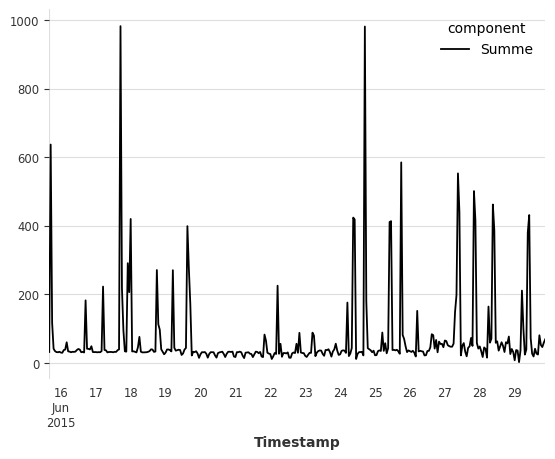

component,Timestamp,Summe
0,2015-06-15 16:00:00,37.462067
1,2015-06-15 17:00:00,44.698383
2,2015-06-15 18:00:00,112.749596
3,2015-06-15 19:00:00,66.003380
4,2015-06-15 20:00:00,36.246323
...,...,...
337,2015-06-29 17:00:00,85.667282
338,2015-06-29 18:00:00,94.629944
339,2015-06-29 19:00:00,59.897812
340,2015-06-29 20:00:00,102.633804


component,Timestamp,Summe
0,2015-06-15 16:00:00,31.879468
1,2015-06-15 17:00:00,636.687600
2,2015-06-15 18:00:00,116.746853
3,2015-06-15 19:00:00,41.369459
4,2015-06-15 20:00:00,34.288429
...,...,...
337,2015-06-29 17:00:00,80.591582
338,2015-06-29 18:00:00,52.420814
339,2015-06-29 19:00:00,46.189453
340,2015-06-29 20:00:00,58.697892


In [47]:
import plotly.graph_objects as go

# Assuming you have imported and prepared your input series appropriately

# Load the XGBoost model from the saved file
model_loaded = XGBModel.load("xgbModel.pkl")

# Make predictions using the loaded model
predicted = model_loaded.predict(342, series=input)
predicted = predicted.pd_dataframe().reset_index()
# Create the trace for predicted values
predicted_trace = go.Scatter(
    x=predicted['Timestamp'],
    y=predicted['Summe'],
    mode='lines',
    name='Predicted'
)
actual_to = actual.pd_dataframe().reset_index()
# Create the trace for actual values
actual_trace = go.Scatter(
    x=actual_to['Timestamp'],
    y=actual_to['Summe'],
    mode='lines',
    name='Actual'
)

# Create the layout for the plot
layout = go.Layout(
    title='Actual vs Predicted',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Value')
)

# Create the figure object
fig = go.Figure(data=[predicted_trace, actual_trace], layout=layout)

fig.show()

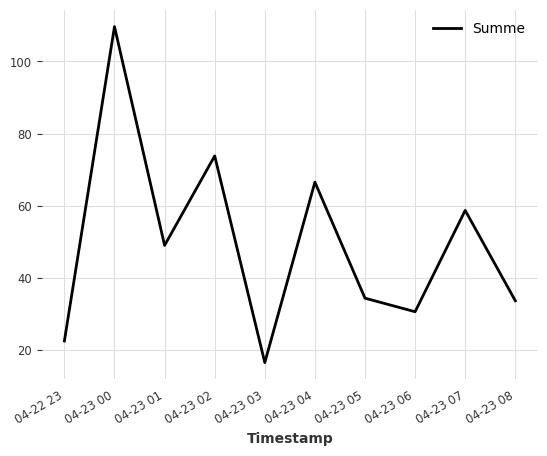

In [14]:

# forecast = model.predict(Horizan)
predictions_xgb = xbg_model.predict(10)
predictions_xgb.plot()

In [ ]:


# Convert train_series into a pandas dataframe and reset index
df_train = train_hour_ts.pd_dataframe().reset_index()

# Convert test_series into a pandas dataframe and reset index
df_test = test_hour_ts.pd_dataframe().reset_index()

# Convert prediction into a pandas dataframe and reset index
forecast_xgb_tm = predictions_xgb.pd_dataframe().reset_index()


x_feature_tm ='Timestamp' 
y_feature_tm ='Summe'
model_name =f'Using XGBModel'

train_test_predicted_plot(
                        df_train,
                        df_test,
                        x_feature_tm,
                        y_feature_tm,
                        forecast_xgb_tm,
                        model_name)
     

In [61]:
test_mae , test_rmse , test_mse,test_mape = calculate_errors(forecast_xgb_tm['Summe'] ,df_test['Summe'])

print(f"MAE : {test_mae} RMSE {test_rmse} MSE {test_mse} MAPE {test_mape}")

MAE : 73.0079095028563 RMSE 120.8385081519661 MSE 14601.945052392777 MAPE 184.52644841719405


In [ ]:
def time_series_models(train_ts,test_ts,Horizan,model_name):
    
    if model_name=='XGBMODEL':
        xbg_model =  XGBModel(lags=200, 
                #   lags_past_covariates=, 
                #   lags_future_covariates=None, 
                output_chunk_length=30,
                likelihood=None, 
                quantiles=None, 
                random_state=32,
                multi_models=True)


        #  Fit the model to your training data
        xbg_model.fit(train_ts)

        # forecast = model.predict(Horizan)
        predictions_xgb = xbg_model.predict(Horizan)

        # Convert train_series into a pandas dataframe and reset index
        df_train = train_ts.pd_dataframe().reset_index()

        # Convert test_series into a pandas dataframe and reset index
        df_test = test_ts.pd_dataframe().reset_index()

        # Convert prediction into a pandas dataframe and reset index
        forecast_xgb_tm = predictions_xgb.pd_dataframe().reset_index()


        x_feature_tm ='Timestamp' 
        y_feature_tm ='Summe'
        model_name =f'Using XGBModel  Model : The Error Mape Value :  {mape(test_day_ts,predictions_xgb)}'

        train_test_predicted_plot(
                                df_train,
                                df_test,
                                x_feature_tm,
                                y_feature_tm,
                                forecast_xgb_tm,
                                model_name)
    elif model_name=='ARIMA':
                
        # these parameters has been found using correlation plot and partial correlation plots
        # i added the description there please read that paragraph # and we can also test 
        # other order by try and test method
        # p: The order of the auto-regressive (AR) model (i.e., the number of lag observations). A time series is considered AR when previous values in the time series are very predictive of later values.

        # d: The degree of differencing.

        # q: The order of the moving average (MA) model. This is essentially the size of the “window” function over your time series data.
        arima_model =  ARIMA(p= 1, #, for Auto regressive parameter
                            d=1  , # for difference to make the data is statioanry
                            q = 2 ,  # for the moving Average,
                            seasonal_order=(1, 1, 2, 11),

                            )
        arima_model.fit(train_ts)


        predictions = arima_model.predict(Horizan)

        # Convert train_series into a pandas dataframe and reset index
        df_train = train_ts.pd_dataframe().reset_index()

        # Convert test_series into a pandas dataframe and reset index
        df_test = test_ts.pd_dataframe().reset_index()

        # Convert prediction into a pandas dataframe and reset index
        forecast = predictions.pd_dataframe().reset_index()


        x_feature ='Timestamp' 
        y_feature='Summe'
        model_name =f'Using ARIMA Model : The Error Mape Value :  {mape(test_ts,predictions)}'
        train_test_predicted_plot(df_train,df_test,x_feature,y_feature,forecast,model_name)
    elif model_name=='FACEBOOKPROPHET':
        
        # Create a Prophet model object
        prophet_model = Prophet( seasonality_mode=   'multiplicative',#    'additive' ,#  'multiplicative',
                        
            changepoint_prior_scale=0.1,
            holidays_prior_scale=0.2,
            seasonality_prior_scale=12,
            changepoint_range=0.8,
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=True,

        )

        # Fit the model to your training data
        prophet_model.fit(train_ts)

        # forecast = model.predict(Horizan)
        predictions_prophet = prophet_model.predict(Horizan)


        # Convert train_series into a pandas dataframe and reset index
        df_train = train_ts.pd_dataframe().reset_index()

        # Convert test_series into a pandas dataframe and reset index
        df_test = test_ts.pd_dataframe().reset_index()

        # Convert prediction into a pandas dataframe and reset index
        forecast_fbPro = predictions_prophet.pd_dataframe().reset_index()


        x_feature_tm ='Timestamp' 
        y_feature_tm ='Summe'
        model_name =f'Using Prophet  Model : The Error Mape Value :  {mape(test_ts,predictions_prophet)}'
        # model_name =f'Using Prophet  Model : The Error Mape Value :  '

        train_test_predicted_plot(
                                df_train,
                                df_test,
                                x_feature_tm,
                                y_feature_tm,
                                forecast_fbPro,
                                model_name)
    elif model_name=='RNN_LSTM':
        my_stopper = EarlyStopping(
        monitor="val_loss",
        patience=5,
        min_delta=0.05,
        mode='min',
    )
        rnn_model = RNNModel(input_chunk_length=30, 
                            model='LSTM', 
                            hidden_dim=100, 
                            n_rnn_layers=100, 
                            dropout=0.0, 
                            training_length=24,
                            loss_fn = torch.nn.MSELoss(),
                            optimizer_cls = torch.optim.Adam,
                            optimizer_kwargs = {'lr': 1e-3},
                            batch_size=32,
                            n_epochs = 100,
                            pl_trainer_kwargs={"callbacks": [my_stopper]},
                            log_tensorboard=True,
                            save_checkpoints=True

                            
                            )



        # Fit the model to your training data
        rnn_model.fit(train_ts,val_series=test_ts)

        # forecast = model.predict(Horizan)
        predictions_rnn = rnn_model.predict(Horizan)


        # Convert train_series into a pandas dataframe and reset index
        df_train = train_ts.pd_dataframe().reset_index()

        # Convert test_series into a pandas dataframe and reset index
        df_test = test_ts.pd_dataframe().reset_index()

        # Convert prediction into a pandas dataframe and reset index
        forecast_fbPro = predictions_rnn.pd_dataframe().reset_index()


        x_feature_tm ='Timestamp' 
        y_feature_tm ='Summe'
        model_name =f'Using RNN-LSTM Model : The Error Mape Value :  {mape(test_ts,predictions_rnn)}'
        # model_name =f'Using Prophet  Model : The Error Mape Value :  '

        train_test_predicted_plot(
                                df_train,
                                df_test,
                                x_feature_tm,
                                y_feature_tm,
                                forecast_fbPro,
                                model_name)


     
train_ts = train_hour_ts
test_ts = test_hour_ts
model_name =  'RNN_LSTM'  
time_series_models(train_ts,test_ts,Horizan,model_name)
      

In [ ]:
train_ts = train_hour_ts
test_ts = test_hour_ts

In [ ]:
from darts.models.forecasting.nbeats import NBEATSModel 
my_stopper = EarlyStopping(
      monitor="val_loss",
      patience=1,
      min_delta=0.05,
      mode='min',
)
nbeat_models = NBEATSModel(input_chunk_length=12, 
                           output_chunk_length=1, 
                           generic_architecture=True, 
                           num_stacks=15, 
                           num_blocks=1, 
                           num_layers=10, 
                           layer_widths=256, 
                           expansion_coefficient_dim=5, 
                           trend_polynomial_degree=2, 
                           dropout=0.0, 
                           activation='ReLU',
                           n_epochs=100,
                           log_tensorboard=True,
                           save_checkpoints=True,
                        pl_trainer_kwargs={"callbacks": [my_stopper]},
)




# Fit the model to your training data
nbeat_models.fit(series = train_ts,val_series = test_ts)

# forecast = model.predict(Horizan)
predictions_nbeats = nbeat_models.predict(Horizan_hour)


# Convert train_series into a pandas dataframe and reset index
df_train = train_ts.pd_dataframe().reset_index()

# Convert test_series into a pandas dataframe and reset index
df_test = test_ts.pd_dataframe().reset_index()

# Convert prediction into a pandas dataframe and reset index
forecast_nbeats = predictions_nbeats.pd_dataframe().reset_index()


x_feature_tm ='Timestamp' 
y_feature_tm ='Summe'
model_name =f'Using Nbeats Model : The Error Mape Value :  {mape(test_ts,predictions_nbeats)}'
# model_name =f'Using Prophet  Model : The Error Mape Value :  '

train_test_predicted_plot(
                        df_train,
                        df_test,
                        x_feature_tm,
                        y_feature_tm,
                        forecast_nbeats,
                        model_name)


In [ ]:
train_ts.pd_dataframe().shape